# Использование auto_arima для прогнозирования временного ряда

In [11]:
!pip install pmdarima -q
!pip install tqdm -q

In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook
import numpy as np
import datetime

## Прогнозирование исходных данных

В качестве показательных данных используются акции компании Apple с секундной градулярностью, всего данные взяты за месяц.

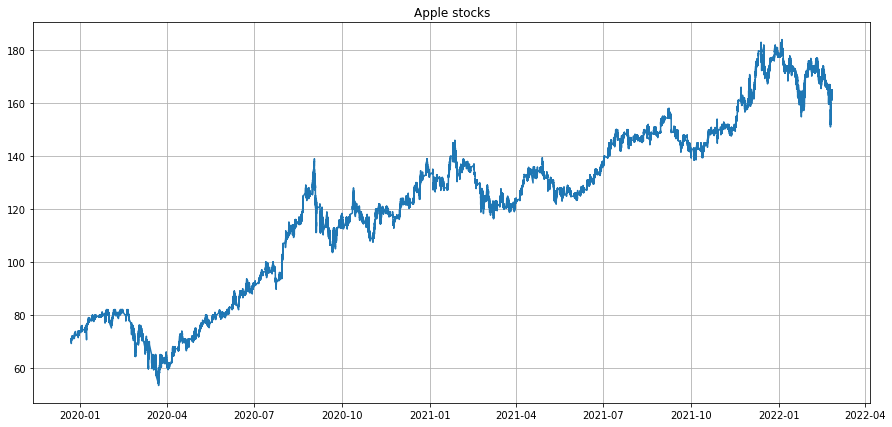

In [21]:
file = 'data/AAPL.csv'
dataset = pd.read_csv(file, index_col='time', parse_dates=['time'])
data = dataset.loc[:, 'close']  # значения акции
data = data.to_frame()
data = data.sort_index()  # сортировка по дате (изначально данные не сортированы)

plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('Apple stocks')
plt.grid(True)
plt.show()

График получился немного прерывистым из-за наличия пропусков в данных.

In [22]:
data.shape

(538237, 1)

In [23]:
data.head()

,close
time,
2019-12-23 07:01:00+00:00,70.7750
2019-12-23 07:03:00+00:00,70.1225
2019-12-23 07:04:00+00:00,70.1175
2019-12-23 07:05:00+00:00,69.8875
2019-12-23 07:06:00+00:00,70.1150


In [24]:
data.tail()

,close
time,
2022-02-25 22:40:00+00:00,164.60
2022-02-25 22:41:00+00:00,164.61
2022-02-25 22:42:00+00:00,164.57
2022-02-25 22:43:00+00:00,164.60
2022-02-25 22:44:00+00:00,164.60


Построение auto_arima модели.

In [25]:
import pmdarima as pm

smodel = pm.auto_arima(data, 
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       start_P=0, max_P=5,
                       start_Q=0, max_Q=5,
                       test='adf',  # ADF-тест для установления стационарности
                       seasonal=True, m=7,  # сезонность по суткам
                       d=1, 
                       D=None, 
                       trace=True,
                       error_action='warn',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-369979.477, Time=117.72 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-291498.386, Time=33.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-350058.584, Time=312.99 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-367787.866, Time=226.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-291499.906, Time=14.80 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-370060.444, Time=375.81 sec


MemoryError: Unable to allocate 1.03 GiB for an array with shape (16, 16, 538238) and data type float64

Составим прогноз данных на сутки

In [77]:
n_periods = 5  # days
n_periods_per_hours = 120  # hours
n_periods_per_minutes = 1440  # minutes = 24 hours
fitted, confint = smodel.predict(n_periods=n_periods_per_minutes, return_conf_int=True)
index_of_fc = pd.date_range(start=data.index[-1], periods = n_periods_per_minutes, freq='T')

fitted_series = pd.DataFrame(fitted, index=index_of_fc, columns=['Value'])

In [58]:
fitted_series

,Value
2022-01-31 13:47:58-05:00,173.231193
2022-01-31 13:48:58-05:00,173.227442
2022-01-31 13:49:58-05:00,173.230244
2022-01-31 13:50:58-05:00,173.239516
2022-01-31 13:51:58-05:00,173.239887
...,...
2022-02-01 13:42:58-05:00,173.237843
2022-02-01 13:43:58-05:00,173.237843
2022-02-01 13:44:58-05:00,173.237843
2022-02-01 13:45:58-05:00,173.237843


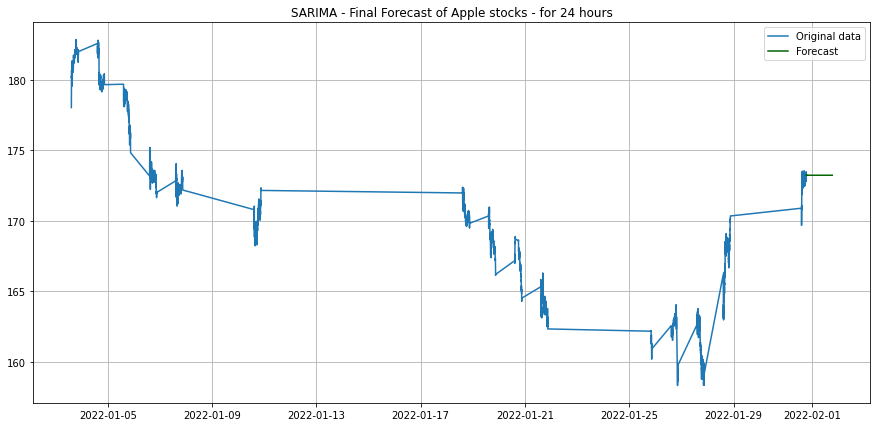

In [78]:
plt.figure(figsize=(15, 7))
plt.plot(data, label='Original data')
plt.plot(fitted_series, color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks - for 24 hours")
plt.grid(True)
plt.legend()
plt.show()

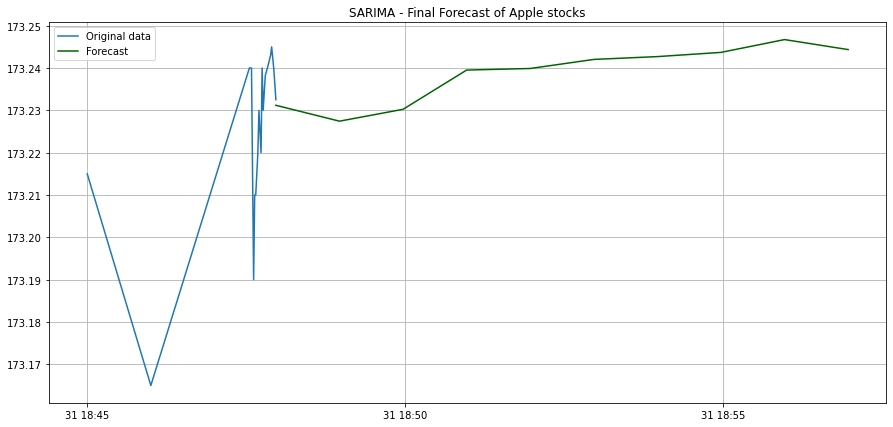

In [79]:
plt.figure(figsize=(15, 7))
plt.plot(data[4900:], label='Original data')
plt.plot(fitted_series[:10], color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks")
plt.grid(True)
plt.legend()
plt.show()

## Прогнозирование аггрегированных данных

Аггрегируем данные по дням и составим прогноз на 5 дней.

In [64]:
data_aggregate = data.resample('D').mean()
data_aggregate = data_aggregate.fillna(data_aggregate.bfill())
data_aggregate.isnull().sum()

Adj Close    0
dtype: int64

In [67]:
data_aggregate.shape

(29, 1)

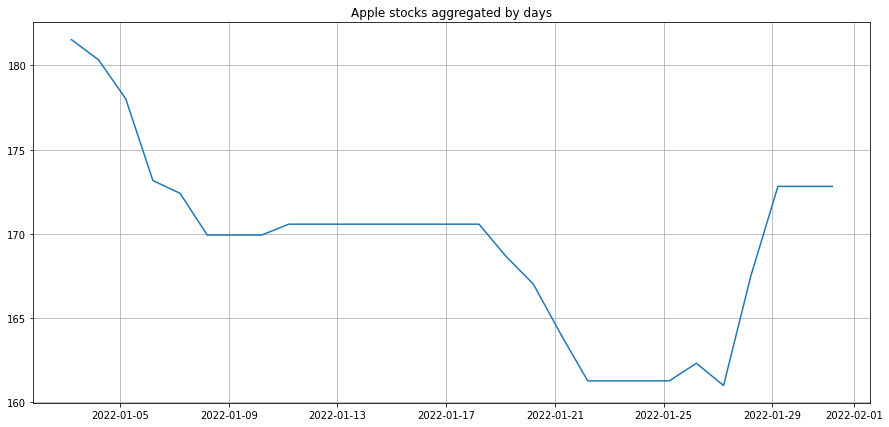

In [71]:
plt.figure(figsize=(15, 7))
plt.plot(data_aggregate)
plt.title('Apple stocks aggregated by days')
plt.grid(True)
plt.show()

In [80]:
smodel_agg = pm.auto_arima(data_aggregate, 
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       start_P=0, max_P=5,
                       start_Q=0, max_Q=5,
                       test='adf',  # ADF-тест для установления стационарности
                       seasonal=True, m=7,  # сезонность по суткам
                       d=1, 
                       D=None, 
                       trace=True,
                       error_action='warn',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=124.752, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=126.720, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=120.343, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=122.462, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=125.294, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=122.773, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=122.328, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=122.334, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=121.897, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=121.845, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=122.343, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=122.343, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=120.699, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=124.343, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4923
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 977.144
Date:                           Sun, 06 Feb 2022   AIC                          -1944.288
Time:                                   13:49:22   BIC                          -1911.781
Sample:                                        0   HQIC                         -1932.886
                                          - 4923                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8144      0.036     22.917      0.000       0.745       0.884
ma.L1         -0.8491      0.034    -24.811      0.000      -0.916      -0.782
ar.S.L7       -0.8250      0.068    -12.187      0.000      -0.958      -0.692
ma.S.L7        0.8535      0.065     13.162      0.000       0.726       0.981
sigma2         0.0394      7e-05    562.021      0.000       0.039       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):          22756882.06
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               3.85   Skew:                             9.29
Prob(H) (two-sided):                  0.00   Kurtosis:                       335.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
n_periods = 7  # days
fitted, confint = smodel_agg.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(start=data_aggregate.index[-1], periods = n_periods, freq='D')

fitted_series = pd.DataFrame(fitted, index=index_of_fc, columns=['Value'])

Построим прогноз на 7 дней.

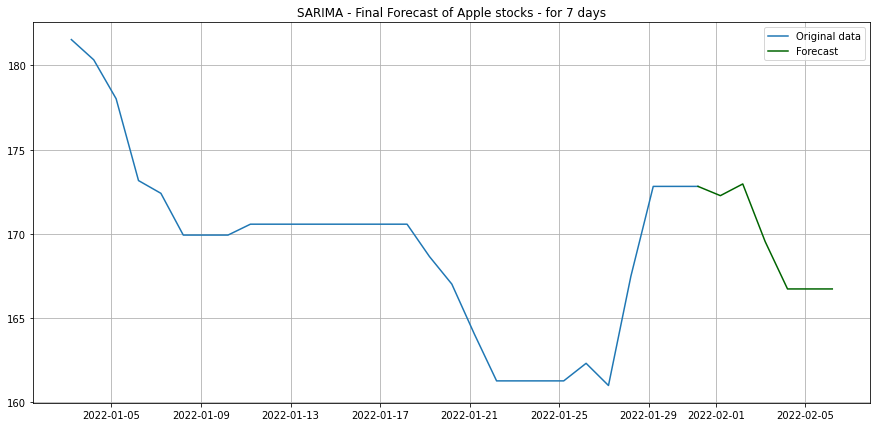

In [82]:
plt.figure(figsize=(15, 7))
plt.plot(data_aggregate, label='Original data')
plt.plot(fitted_series, color='darkgreen', label='Forecast')
plt.title("SARIMA - Final Forecast of Apple stocks - for 7 days")
plt.grid(True)
plt.legend()
plt.show()